成功加载metadata，包含 600 个说话人
总共 56666 个语音文件
=== 可视化示例文件 ===
分析文件: uttr-18e375195dc146fd8d14b8a322c29b90.pt


C:\Users\yukot\AppData\Local\Temp\ipykernel_25156\313096914.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel_features = torch.load(full_path)


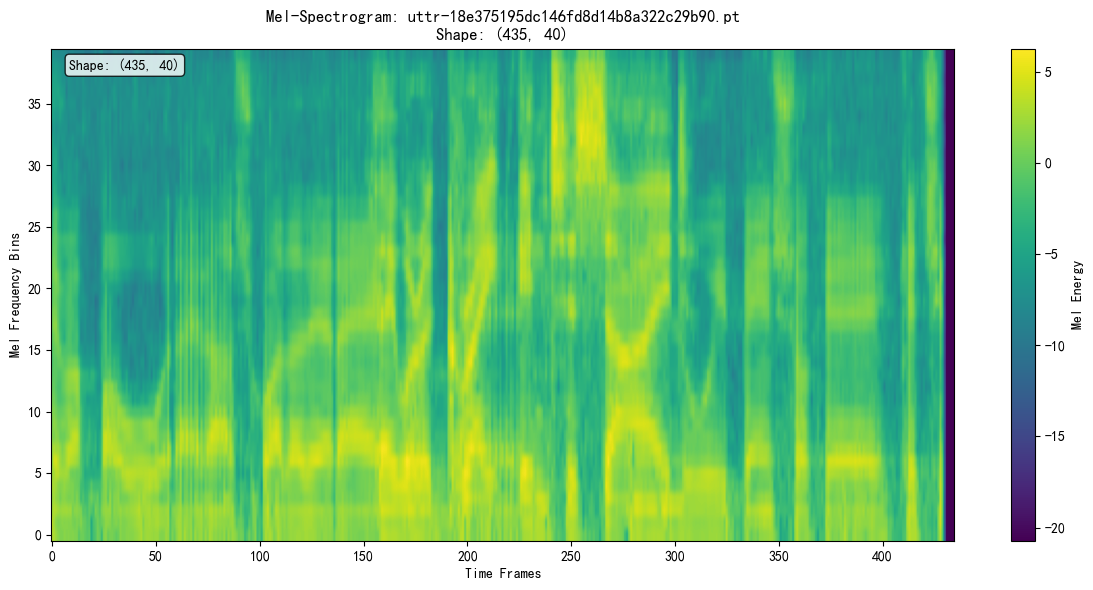


=== 分析长度分布 ===
正在分析长度分布...

=== 长度分布统计 ===
总文件数: 56666
平均长度: 658.09 帧
中位数长度: 541.00 帧
最短长度: 91 帧
最长长度: 7193 帧
标准差: 368.16 帧


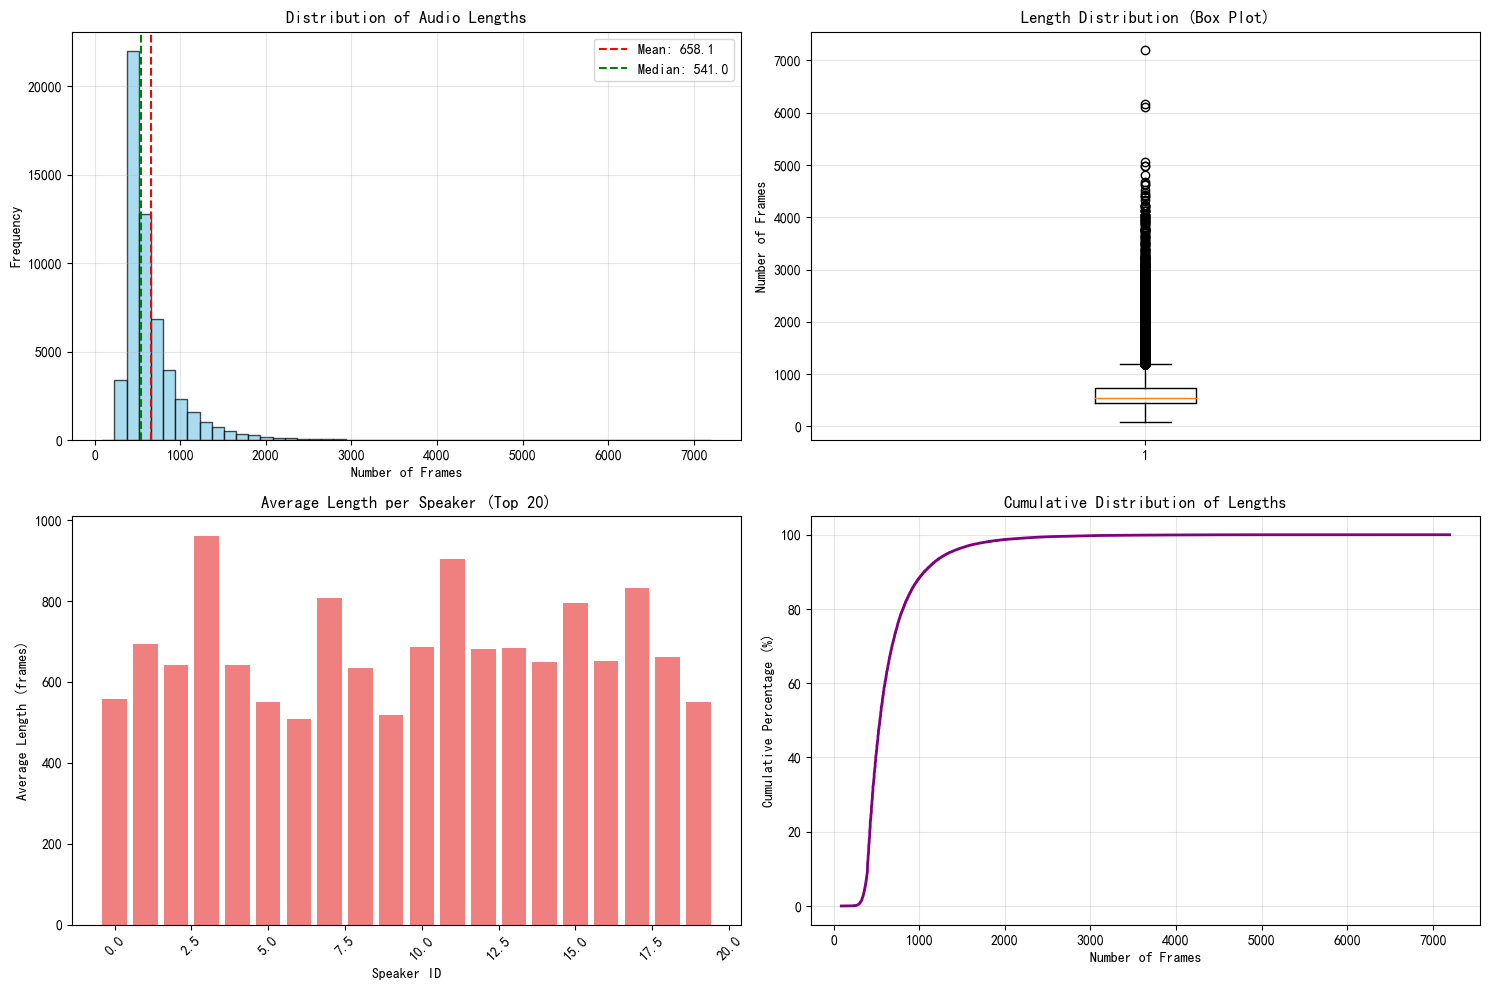


=== 随机样本对比 ===


C:\Users\yukot\AppData\Local\Temp\ipykernel_25156\313096914.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mel_features = torch.load(full_path)


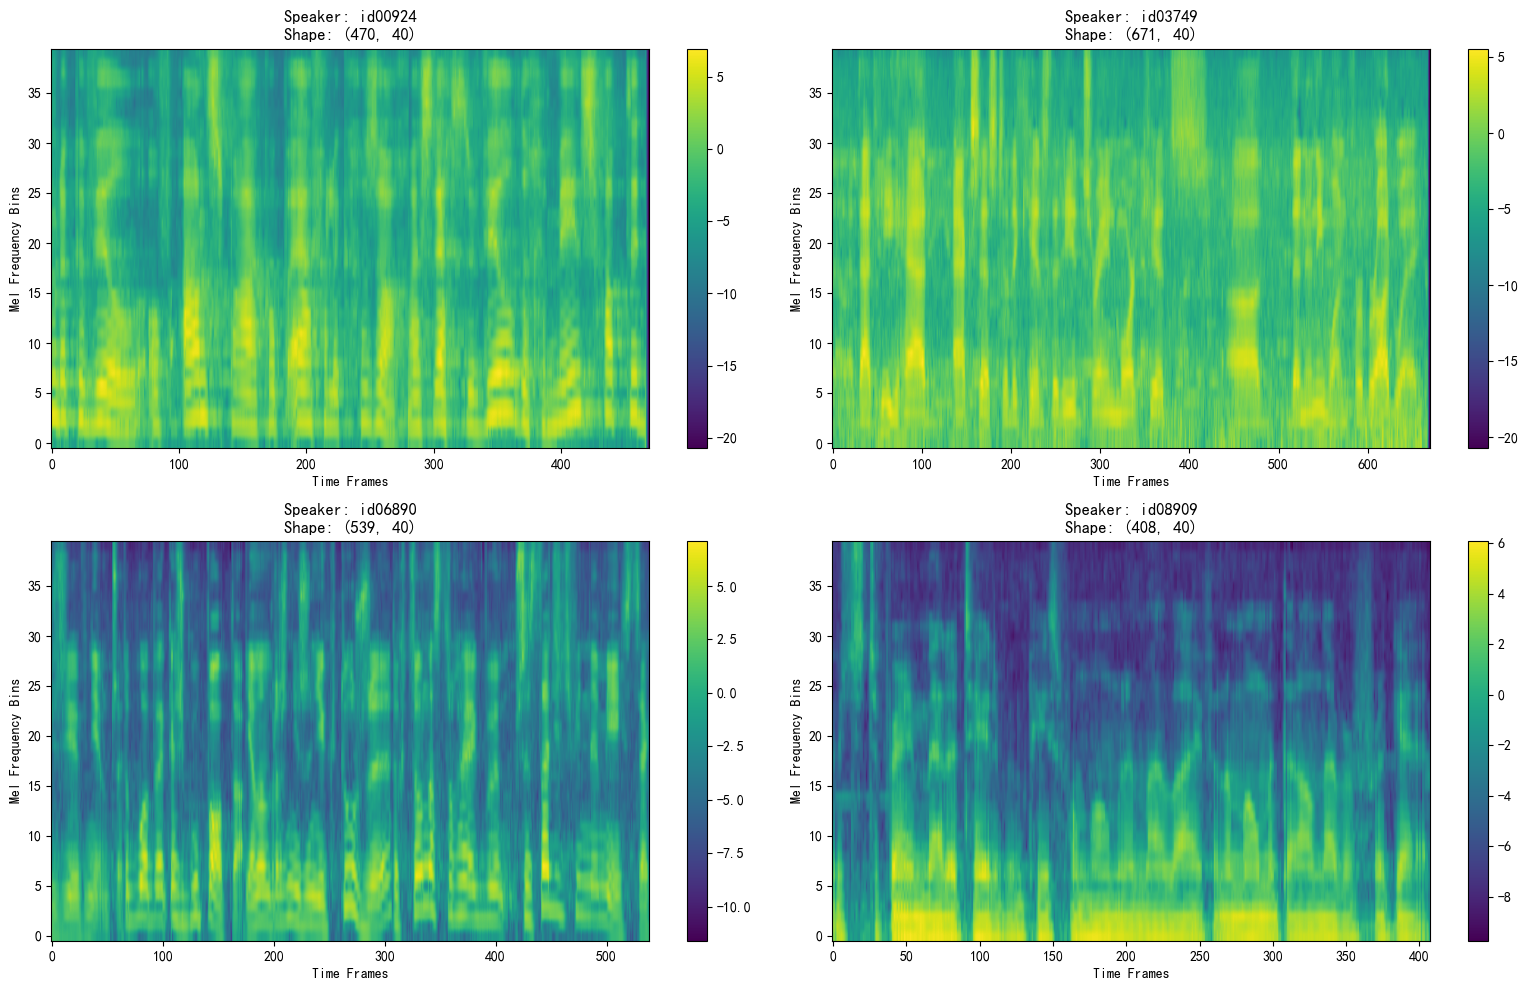


=== 数据集统计 ===
说话人数量: 600
总文件数: 56666
平均长度: 658.1 帧
总时长估计: 372914.0 秒 (假设每帧10ms)


In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class AudioFeatureAnalyzer:
    def __init__(self, data_dir):
        """
        初始化音频特征分析器
        
        Args:
            data_dir: Dataset文件夹路径
        """
        self.data_dir = Path(data_dir)
        self.metadata = self.load_metadata()
        self.speaker_info = self.collect_speaker_info()
        
    def load_metadata(self):
        """加载metadata.json文件"""
        metadata_path = self.data_dir / "metadata.json"
        if not metadata_path.exists():
            print(f"警告: {metadata_path} 不存在")
            return None
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        print(f"成功加载metadata，包含 {len(metadata['speakers'])} 个说话人")
        return metadata
    
    def collect_speaker_info(self):
        """收集所有说话人的信息"""
        if self.metadata is None:
            return {}
            
        speaker_info = {}
        total_utterances = 0
        
        for speaker_id, utterances in self.metadata['speakers'].items():
            speaker_info[speaker_id] = {
                'utterance_count': len(utterances),
                'feature_paths': [utt['feature_path'] for utt in utterances],
                'mel_lengths': [utt.get('mel_len', 0) for utt in utterances]
            }
            total_utterances += len(utterances)
        
        print(f"总共 {total_utterances} 个语音文件")
        return speaker_info
    
    def load_feature_file(self, feature_path):
        """
        加载单个特征文件
        
        Args:
            feature_path: 特征文件路径（相对于data_dir）
            
        Returns:
            mel_features: torch.Tensor, 形状 (N, 40)
        """
        full_path = self.data_dir / feature_path
        if not full_path.exists():
            print(f"文件不存在: {full_path}")
            return None
            
        try:
            mel_features = torch.load(full_path)
            return mel_features
        except Exception as e:
            print(f"加载文件失败 {full_path}: {e}")
            return None
    
    def visualize_single_mel(self, feature_path, figsize=(12, 6)):
        """
        可视化单个mel-spectrogram
        
        Args:
            feature_path: 特征文件路径
            figsize: 图片大小
        """
        mel_features = self.load_feature_file(feature_path)
        if mel_features is None:
            return
        
        # 确保是numpy数组
        if isinstance(mel_features, torch.Tensor):
            mel_features = mel_features.numpy()
        
        plt.figure(figsize=figsize)
        
        # 转置以便正确显示（频率轴在y轴）
        plt.imshow(mel_features.T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Mel Energy')
        plt.xlabel('Time Frames')
        plt.ylabel('Mel Frequency Bins')
        plt.title(f'Mel-Spectrogram: {feature_path}\nShape: {mel_features.shape}')
        
        # 添加形状信息
        plt.text(0.02, 0.98, f'Shape: ({mel_features.shape[0]}, {mel_features.shape[1]})', 
                transform=plt.gca().transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        return mel_features
    
    def analyze_length_distribution(self):
        """分析音频长度分布"""
        all_lengths = []
        speaker_lengths = defaultdict(list)
        
        print("正在分析长度分布...")
        
        for speaker_id, info in self.speaker_info.items():
            for feature_path in info['feature_paths']:
                mel_features = self.load_feature_file(feature_path)
                if mel_features is not None:
                    length = len(mel_features)
                    all_lengths.append(length)
                    speaker_lengths[speaker_id].append(length)
        
        # 统计信息
        all_lengths = np.array(all_lengths)
        
        print(f"\n=== 长度分布统计 ===")
        print(f"总文件数: {len(all_lengths)}")
        print(f"平均长度: {np.mean(all_lengths):.2f} 帧")
        print(f"中位数长度: {np.median(all_lengths):.2f} 帧")
        print(f"最短长度: {np.min(all_lengths)} 帧")
        print(f"最长长度: {np.max(all_lengths)} 帧")
        print(f"标准差: {np.std(all_lengths):.2f} 帧")
        
        # 可视化
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. 整体长度分布直方图
        axes[0, 0].hist(all_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(np.mean(all_lengths), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(all_lengths):.1f}')
        axes[0, 0].axvline(np.median(all_lengths), color='green', linestyle='--', 
                          label=f'Median: {np.median(all_lengths):.1f}')
        axes[0, 0].set_xlabel('Number of Frames')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Audio Lengths')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. 长度分布箱线图
        axes[0, 1].boxplot(all_lengths, vert=True)
        axes[0, 1].set_ylabel('Number of Frames')
        axes[0, 1].set_title('Length Distribution (Box Plot)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. 每个说话人的平均长度
        speaker_avg_lengths = {spk: np.mean(lengths) for spk, lengths in speaker_lengths.items()}
        speakers = list(speaker_avg_lengths.keys())[:20]  # 只显示前20个说话人
        avg_lengths = [speaker_avg_lengths[spk] for spk in speakers]
        
        axes[1, 0].bar(range(len(speakers)), avg_lengths, color='lightcoral')
        axes[1, 0].set_xlabel('Speaker ID')
        axes[1, 0].set_ylabel('Average Length (frames)')
        axes[1, 0].set_title('Average Length per Speaker (Top 20)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 4. 累积分布
        sorted_lengths = np.sort(all_lengths)
        cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
        axes[1, 1].plot(sorted_lengths, cumulative, color='purple', linewidth=2)
        axes[1, 1].set_xlabel('Number of Frames')
        axes[1, 1].set_ylabel('Cumulative Percentage (%)')
        axes[1, 1].set_title('Cumulative Distribution of Lengths')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return all_lengths, speaker_lengths
    
    def compare_random_samples(self, num_samples=4):
        """随机选择几个样本进行对比"""
        all_paths = []
        for speaker_id, info in self.speaker_info.items():
            for path in info['feature_paths']:
                all_paths.append((speaker_id, path))
        
        # 随机选择样本
        selected_indices = np.random.choice(len(all_paths), size=min(num_samples, len(all_paths)), replace=False)
        selected_samples = [all_paths[i] for i in selected_indices]
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()
        
        for idx, (speaker_id, feature_path) in enumerate(selected_samples):
            mel_features = self.load_feature_file(feature_path)
            if mel_features is not None:
                if isinstance(mel_features, torch.Tensor):
                    mel_features = mel_features.numpy()
                
                im = axes[idx].imshow(mel_features.T, aspect='auto', origin='lower', cmap='viridis')
                axes[idx].set_title(f'Speaker: {speaker_id}\nShape: {mel_features.shape}')
                axes[idx].set_xlabel('Time Frames')
                axes[idx].set_ylabel('Mel Frequency Bins')
                plt.colorbar(im, ax=axes[idx])
        
        plt.tight_layout()
        plt.show()
    
    def get_sample_file_path(self, speaker_id=None):
        """获取一个示例文件路径"""
        if speaker_id is None:
            # 随机选择一个说话人
            speaker_id = list(self.speaker_info.keys())[0]
        
        if speaker_id in self.speaker_info:
            feature_path = self.speaker_info[speaker_id]['feature_paths'][0]
            return feature_path
        else:
            print(f"说话人 {speaker_id} 不存在")
            return None

# 使用示例
def main():
    # 1. 初始化分析器
    analyzer = AudioFeatureAnalyzer("Dataset")  # 你的Dataset文件夹路径
    
    # 2. 获取一个示例文件并可视化
    print("=== 可视化示例文件 ===")
    sample_path = analyzer.get_sample_file_path()
    if sample_path:
        print(f"分析文件: {sample_path}")
        mel_features = analyzer.visualize_single_mel(sample_path)
    
    # 3. 分析长度分布
    print("\n=== 分析长度分布 ===")
    all_lengths, speaker_lengths = analyzer.analyze_length_distribution()
    
    # 4. 对比多个随机样本
    print("\n=== 随机样本对比 ===")
    analyzer.compare_random_samples(num_samples=4)
    
    # 5. 打印一些统计信息
    print(f"\n=== 数据集统计 ===")
    print(f"说话人数量: {len(analyzer.speaker_info)}")
    
    total_files = sum(info['utterance_count'] for info in analyzer.speaker_info.values())
    print(f"总文件数: {total_files}")
    
    if all_lengths is not None and len(all_lengths) > 0:
        print(f"平均长度: {np.mean(all_lengths):.1f} 帧")
        print(f"总时长估计: {np.sum(all_lengths) * 0.01:.1f} 秒 (假设每帧10ms)")

if __name__ == "__main__":
    main()